In [76]:
from tqdm import tqdm
from functools import partial
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt
from celluloid import Camera

from tsmoothie.utils_func import sim_randomwalk, sim_seasonal_data
from tsmoothie.smoother import *

%matplotlib inline

In [108]:
class SmoothAnomalyDetection:
    """
    使用时间序列光滑模型进行异常检测
    """
    
    def __init__(self, data, method: str = "convolution", window_len: int = 20, gif_filename = None) -> None:
        """
        data (_type_): _description_
        timesteps (int, optional): _description_. Defaults to 200.
        window_len (int, optional): _description_. Defaults to 20.
        """
        self.data = data
        self.n_series = data.shape[0]
        self.timesteps = data.shape[1]
        self.method = method
        self.window_len = window_len
        self.gif_filename = gif_filename
        self.series = defaultdict(partial(
            np.ndarray, 
            shape = (self.n_series, 1), 
            dtype = "float32"
        ))

    def Step(self):
        self.PlotRealTimeGif()
        self.PlotResult()
    
    def Parpare(self):
        pass

    def PlotHistory(self, ax, timestep, is_anomaly, color = "blue", **pltargs):
        # 序列索引
        position_range = np.arange(0, timestep)
        # 绘制置信区间
        ax.fill_between(
            position_range[self.window_len:],
            pltargs["low"][1:], 
            pltargs["up"][1:],
            color = color,
            alpha = 0.2
        )
        # 绘制历史数据点和异常点
        if is_anomaly:
            ax.scatter(timestep - 1, pltargs["original"][-1], c = "red")
        else:
            ax.scatter(timestep - 1, pltargs["original"][-1], c = "black")
        # TODO
        ax.scatter(timestep - 1, pltargs["smooth"][-1], c = color)
        ax.plot(position_range, pltargs["original"][1:], ".k")
        ax.plot(position_range[self.window_len:], pltargs["smooth"][1:], color = color, linewidth = 3)
        # TODO
        if "anomaly_id" in pltargs.keys():
            if pltargs["anomaly_id"].sum() > 0:
                not_zeros = pltargs["anomaly_id"][pltargs["anomaly_id"] != 0] - 1
                ax.scatter(not_zeros, pltargs["original"][1:][not_zeros], c = "red", alpha = 1.0)

    def PlotRealTimeGif(self):
        # 绘图设置
        fig = plt.figure(figsize = (18, 10))
        axs = [plt.subplot(self.n_series, 1, ax + 1) for ax in range(self.n_series)]
        # GIF 绘图设置
        camera = Camera(fig)
        # recovered data
        recovered = np.copy(self.data)
        # 实时数据异常值检测
        for timestep in tqdm(range(self.timesteps + 1), total = (self.timesteps + 1)):
            if timestep > self.window_len:
                # 使用光滑模型进行异常检测
                if self.method == "convolution":
                    is_anomaly = self.ConvolutionSmoothSeries(timestep)
                elif self.method == "exponential":
                    is_anomaly = self.ExponentialSmoothSeries(timestep)
                elif self.method == "decompose":
                    is_anomaly = self.DecomposeSmoothSeries(timestep)
                elif self.method == "decompose_shift":
                    is_anomaly = self.DecomposeShiftSmoothSeries(timestep, recovered)
                # 绘图
                for s in range(self.n_series):
                    pltargs = {
                        key: value[s, :] \
                        for key, value in self.series.items()
                    }
                    self.PlotHistory(axs[s], timestep, is_anomaly[s], color = 'blue', **pltargs)
                camera.snap()
            
            if timestep >= self.timesteps:
                continue
            self.series["original"] = np.hstack([self.series["original"], self.data[:, [timestep]]])
            if self.method == "decompose_shift":
                self.series["recovered"] = np.hstack([self.series["recovered"], recovered[:, [timestep]]])
        # 绘制 GIF 图
        if self.gif_filename:
            print("Creating GIF...")
            camera._photos = [camera._photos[-1]] + camera._photos
            animation = camera.animate()
            animation.save(self.gif_filename)
            plt.close(fig)
            print("Done")

    def PlotResult(self):
        """
        异常检测结果可视化
        """
        # 绘图设置
        fig = plt.figure(figsize = (18, 10))
        axs = [plt.subplot(self.n_series, 1, ax + 1) for ax in range(self.n_series)]
        for i, ax in enumerate(axs):
            # 序列索引
            position_range = np.arange(self.window_len, self.timesteps)
            # 原始数据点
            ax.plot(self.series["original"][i, 1:], ".k")
            # 原始数据点的光滑曲线
            ax.plot(position_range, self.series["smooth"][i, 1:], c = "blue", linewidth = 3)
            # 光滑曲线置信区间
            ax.fill_between(
                position_range, 
                self.series["low"][i, 1:], 
                self.series["up"][i, 1:], 
                color = "blue", 
                alpha = 0.2
            )
            # 异常点 
            anomaly_id = self.series["anomaly_id"][i][self.series["anomaly_id"][i] != 0] - 1
            if len(anomaly_id) > 0:
                ax.scatter(anomaly_id, self.series["original"][i, 1:][anomaly_id], c = "red", alpha = 1.0)
        plt.show()

    def ConvolutionSmoothSeries(self, timestep):
        """
        卷积光滑异常值检测
            - 数据没有季节性和趋势
        """
        # 光滑器
        smoother = ConvolutionSmoother(window_len = self.window_len, window_type = "ones")
        # 光滑处理
        smoother.smooth(self.series["original"][:, -self.window_len:])
        # 光滑序列
        self.series["smooth"] = np.hstack([self.series["smooth"], smoother.smooth_data[:, [-1]]])
        # 光滑序列区间
        _low, _up = smoother.get_intervals('sigma_interval', n_sigma = 2)
        self.series['low'] = np.hstack([self.series['low'], _low[:, [-1]]])
        self.series['up'] = np.hstack([self.series['up'], _up[:, [-1]]])
        # 异常检测
        is_anomaly = np.logical_or(
            self.series["original"][:, -1] > self.series["up"][:, -1],
            self.series["original"][:, -1] < self.series["low"][:, -1],
        ).reshape(-1, 1)
        if is_anomaly.any():
            self.series["anomaly_id"] = np.hstack([self.series["anomaly_id"], is_anomaly * timestep]).astype(int)        
        
        return is_anomaly

    def ExponentialSmoothSeries(self, timestep):
        """
        指数光滑异常值检测
            - 数据有季节性没有趋势
        """
        # 光滑器
        smoother = ExponentialSmoother(window_len = self.window_len // 2, alpha = 0.4)
        # 光滑处理
        smoother.smooth(self.series["original"][:, -self.window_len:])
        # 光滑序列
        self.series["smooth"] = np.hstack([self.series["smooth"], smoother.smooth_data[:, [-1]]])
        # 光滑序列区间
        _low, _up = smoother.get_intervals('sigma_interval', n_sigma = 2)
        self.series['low'] = np.hstack([self.series['low'], _low[:, [-1]]])
        self.series['up'] = np.hstack([self.series['up'], _up[:, [-1]]])
        # 异常检测
        is_anomaly = np.logical_or(
            self.series["original"][:, -1] > self.series["up"][:, -1],
            self.series["original"][:, -1] < self.series["low"][:, -1],
        ).reshape(-1, 1)
        if is_anomaly.any():
            self.series["anomaly_id"] = np.hstack([self.series["anomaly_id"], is_anomaly * timestep]).astype(int)        
        
        return is_anomaly

    def DecomposeSmoothSeries(self, timestep):
        """
        分解光滑异常值检测
            - 数据有季节性，趋势
        """
        # 光滑器
        smoother = DecomposeSmoother(
            smooth_type = "convolution", 
            periods = 24, 
            window_len = self.window_len // 3, 
            window_type = "ones"
        )
        # 光滑处理
        smoother.smooth(self.series["original"][:, -self.window_len:])
        # 光滑序列
        self.series["smooth"] = np.hstack([self.series["smooth"], smoother.smooth_data[:, [-1]]])
        # 光滑序列区间
        _low, _up = smoother.get_intervals('sigma_interval', n_sigma = 2.5)
        self.series['low'] = np.hstack([self.series['low'], _low[:, [-1]]])
        self.series['up'] = np.hstack([self.series['up'], _up[:, [-1]]])
        # 异常检测
        is_anomaly = np.logical_or(
            self.series["original"][:, -1] > self.series["up"][:, -1],
            self.series["original"][:, -1] < self.series["low"][:, -1],
        ).reshape(-1, 1)
        if is_anomaly.any():
            self.series["anomaly_id"] = np.hstack([self.series["anomaly_id"], is_anomaly * timestep]).astype(int)        
        
        return is_anomaly
    
    def DecomposeShiftSmoothSeries(self, timestep, recovered):
        """
        分解光滑异常值检测
            - 数据有季节性，趋势
        """
        # 光滑器
        smoother = DecomposeSmoother(
            smooth_type = "convolution", 
            periods = 24, 
            window_len = self.window_len, 
            window_type = "ones"
        )
        # 光滑处理
        smoother.smooth(self.series["recovered"][:, -self.window_len:])
        # 光滑序列
        self.series["smooth"] = np.hstack([self.series["smooth"], smoother.smooth_data[:, [-1]]])
        # 光滑序列区间
        _low, _up = smoother.get_intervals('sigma_interval', n_sigma = 4)
        self.series['low'] = np.hstack([self.series['low'], _low[:, [-1]]])
        self.series['up'] = np.hstack([self.series['up'], _up[:, [-1]]])
        # 异常检测
        is_anomaly = np.logical_or(
            self.series["original"][:, -1] > self.series["up"][:, -1],
            self.series["original"][:, -1] < self.series["low"][:, -1],
        ).reshape(-1, 1)
        if is_anomaly.any():
            anomaly_series = np.where(is_anomaly)[0]
            self.series["anomaly_id"] = np.hstack([self.series["anomaly_id"], is_anomaly * timestep]).astype(int)
            recovered[anomaly_series, timestep] = smoother.smooth_data[anomaly_series, [-1]]
        
        return is_anomaly


# 模拟数据-随机游走

In [82]:
np.random.seed(42)
n_series, timesteps = 3, 200

data = sim_randomwalk(
    n_series = n_series,
    timesteps = timesteps,
    process_noise = 10,
    measure_noise = 30,
)
data.shape

(3, 200)

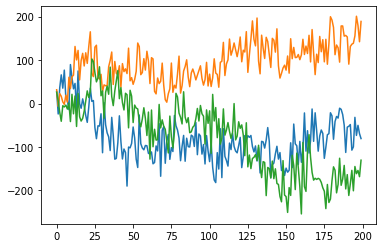

In [83]:
plt.plot(data.T)
np.set_printoptions(False)

## 模型

100%|████████████████████████████████████████████████████████| 201/201 [00:05<00:00, 33.94it/s]


Creating GIF...
Done


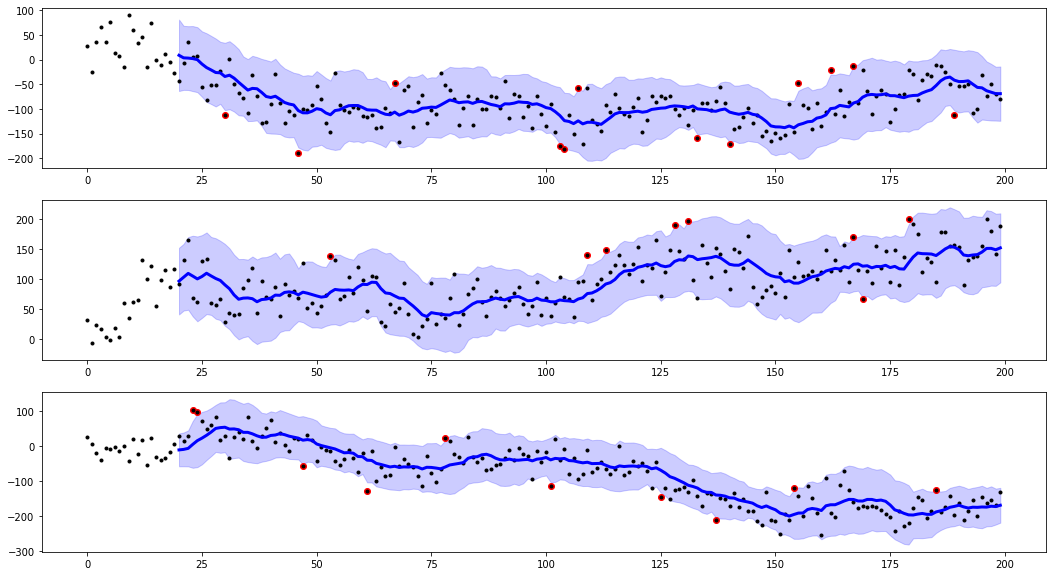

In [85]:
smoother_ad = SmoothAnomalyDetection(data, method = "convolution", window_len = 20, gif_filename = "animation1.gif")
smoother_ad.Step()

![animation](animation1.gif)

# 模拟数据-季节性数据(无趋势)

In [86]:
np.random.seed(42)
n_series, timesteps = 3, 200

data = sim_seasonal_data(
    n_series = n_series,
    timesteps = timesteps,
    freq = 24,
    measure_noise = 20,
    amp = [30, 40, 50],
)
data.shape

(3, 200)

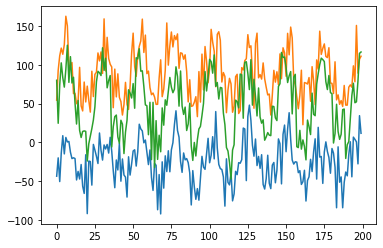

In [87]:
plt.plot(data.T)
np.set_printoptions(False)

## 模型

100%|████████████████████████████████████████████████████████| 201/201 [00:05<00:00, 34.13it/s]


Creating GIF...
Done


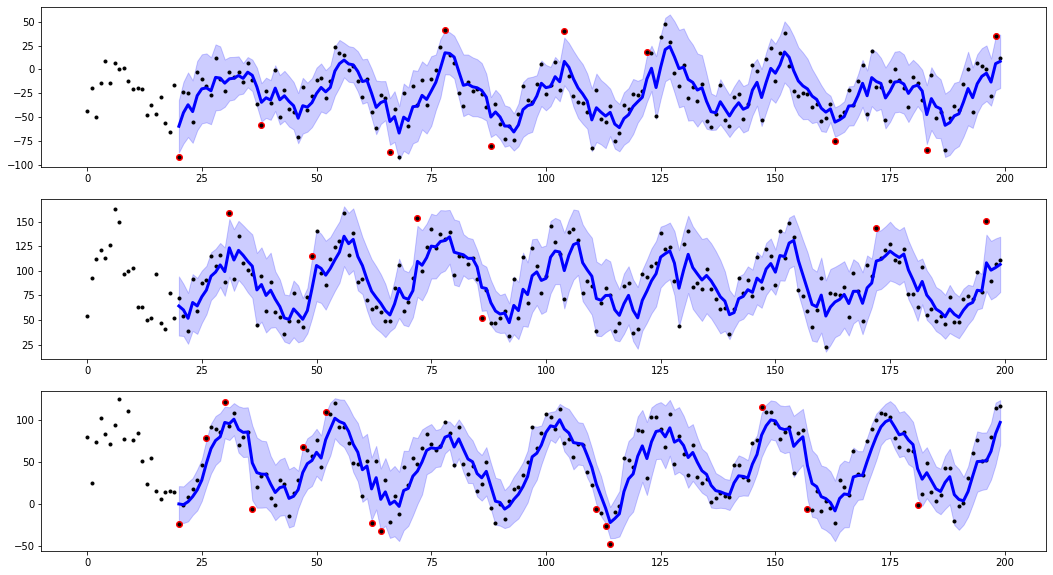

In [88]:
smoother_ad = SmoothAnomalyDetection(
    data, 
    method = "exponential", 
    window_len = 20, 
    gif_filename = "animation2.gif"
)
smoother_ad.Step()

![animation](animation2.gif)

# 模拟数据-季节数据(有趋势)

In [92]:
np.random.seed(42)
n_series, timesteps = 3, 600

randomwalk = sim_randomwalk(
    n_series = n_series,
    timesteps = timesteps,
    process_noise = 1,
    measure_noise = 0,
)
seasons = sim_seasonal_data(
    n_series = n_series,
    timesteps = timesteps,
    freq = 24,
    measure_noise = 4,
    level = 0,
    amp = 10,
)
data = randomwalk + seasons
data.shape

(3, 600)

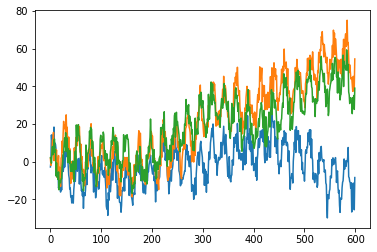

In [93]:
plt.plot(data.T)
np.set_printoptions(False)

## 模型

100%|████████████████████████████████████████████████████████| 601/601 [00:26<00:00, 22.28it/s]


Creating GIF...
Done


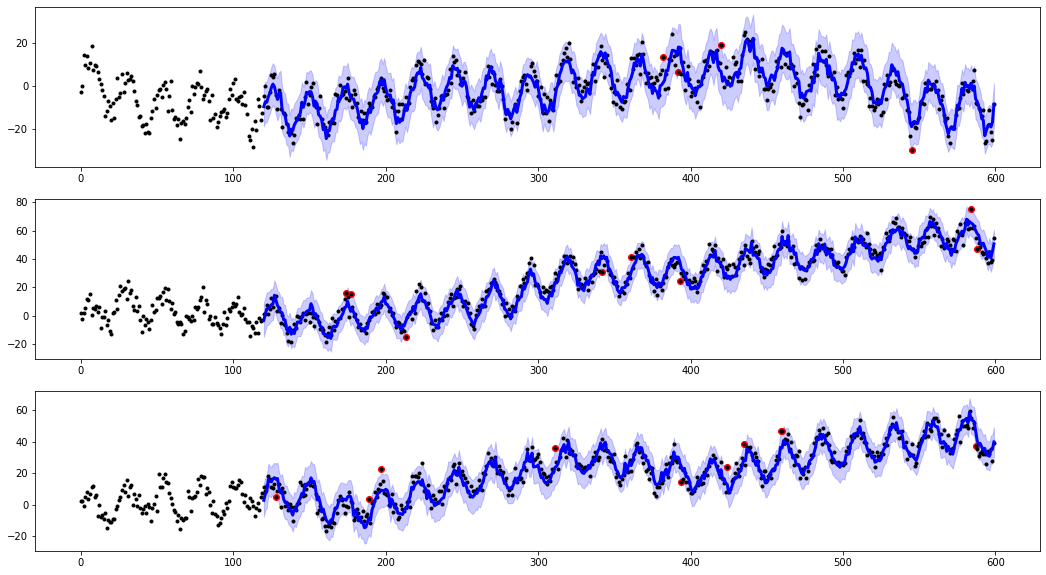

In [94]:
smoother_ad = SmoothAnomalyDetection(
    data, 
    method = "decompose", 
    window_len = 24 * 5, 
    gif_filename = "animation3.gif"
)
smoother_ad.Step()

![animation](animation3.gif)

# 模拟数据-季节数据(有趋势和shift)

In [103]:
np.random.seed(42)
n_series, timesteps = 3, 600

randomwalk = sim_randomwalk(
    n_series = n_series,
    timesteps = timesteps,
    process_noise = 1,
    measure_noise = 0,
)
seasons = sim_seasonal_data(
    n_series = n_series,
    timesteps = timesteps,
    freq = 24,
    measure_noise = 4,
    level = 0,
    amp = 10,
)
data = randomwalk + seasons
data[:, 300:380] = data[:, 300:380] + 40
data.shape

(3, 600)

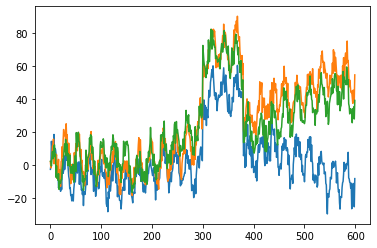

In [104]:
plt.plot(data.T)
np.set_printoptions(False)

## 模型

100%|████████████████████████████████████████████████████████| 601/601 [00:25<00:00, 23.65it/s]


Creating GIF...
Done


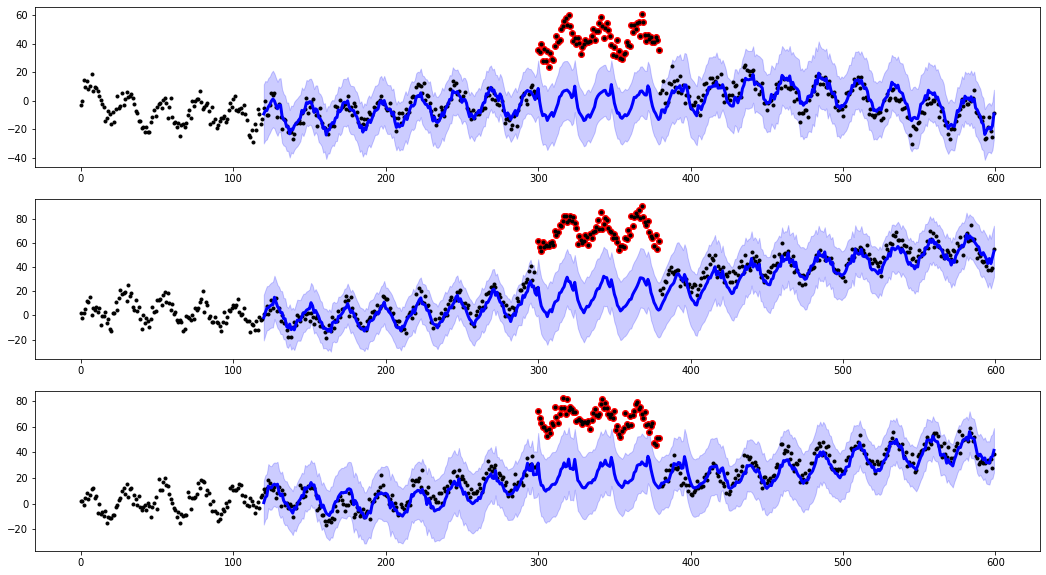

In [109]:
smoother_ad = SmoothAnomalyDetection(
    data, 
    method = "decompose_shift", 
    window_len = 24 * 5, 
    gif_filename = "animation4.gif"
)
smoother_ad.Step()

![animation](animation4.gif)